## Import 

In [1]:
import cv2
import time
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mmdet.apis import inference_detector, init_detector
from mmpose.apis import inference_topdown, init_model as init_pose_estimator
from mmpose.structures import merge_data_samples
from mmpose.evaluation.functional import nms
from mmengine.registry import init_default_scope
from mmpose.registry import VISUALIZERS
import mmcv
from mmpose.utils import adapt_mmdet_pipeline
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.pardir, os.pardir)))
from MediaLoader.utils import get_video_info_dict

## Inferencer and Model

Device and image

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device : ", device)

Device :  cuda


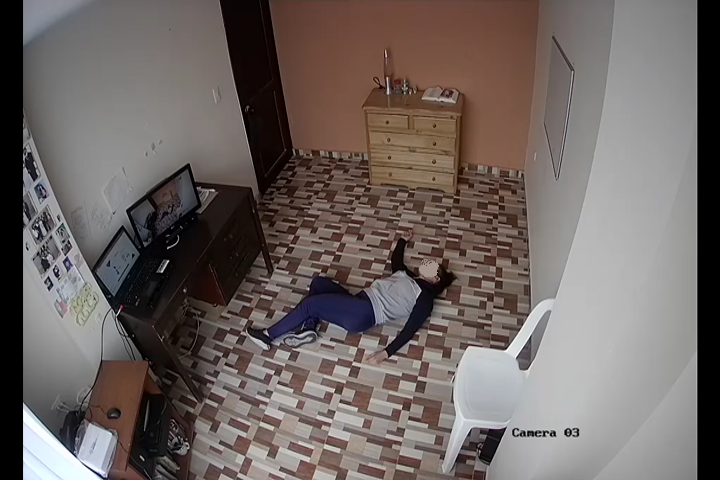

In [3]:
img_path = "../../Data/Fall/Dataset_CAUCAFall/CAUCAFall/Subject.1/Fall backwards/cas100111.png"
img_pil = Image.open(img_path)
img = np.array(img_pil)
img_pil

Build Detector and Estimator

In [4]:
# model to use
pose_config = '../../mmpose/projects/rtmpose/rtmpose/body_2d_keypoint/rtmpose-m_8xb256-420e_coco-256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-aic-coco_pt-aic-coco_420e-256x192-63eb25f7_20230126.pth'

det_config='../../mmpose/projects/rtmpose/rtmdet/person/rtmdet_nano_320-8xb32_coco-person.py'
det_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth'

In [5]:
# build detector
detector = init_detector(det_config, det_checkpoint, device=device)
detector.cfg = adapt_mmdet_pipeline(detector.cfg)

# build pose estimator
pose_estimator = init_pose_estimator(pose_config, pose_checkpoint, device=device)

# build visualizer
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.alpha = 0.8
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(
    pose_estimator.dataset_meta, skeleton_style='openpose')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-aic-coco_pt-aic-coco_420e-256x192-63eb25f7_20230126.pth
08/10 08:42:39 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [6]:
def process_one_image_with_bbox(img_path,
                      pose_estimator,
                      visualizer=None,
                      show_interval=0):
    """Visualize predicted keypoints (and heatmaps) of one image."""

    img_pil = Image.open(img_path)
    img = np.array(img_pil)

    # imposed bbox
    with open(img_path.replace("png", "txt"), 'rb') as f:
        bbox_yolo = np.loadtxt(f, delimiter=' ', dtype=np.float32)[1:] # YOLO format : [x-center, y-center, width, height]
        # We convert it to the COCO format : [xmin, ymin, xmax, ymax]
        bbox = np.zeros(4)
        bbox[0] = (bbox_yolo[0] - bbox_yolo[2] / 2) * img_pil.width
        bbox[1] = (bbox_yolo[1] - bbox_yolo[3] / 2) * img_pil.height
        bbox[2] = (bbox_yolo[0] + bbox_yolo[2] / 2) * img_pil.width
        bbox[3] = (bbox_yolo[1] + bbox_yolo[3] / 2) * img_pil.height
    bboxes = np.expand_dims(bbox, axis=0)

    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img, bboxes)
    data_samples = merge_data_samples(pose_results)

    # show the results
    if isinstance(img, str):
        img = mmcv.imread(img, channel_order='rgb')
    elif isinstance(img, np.ndarray):
        img = mmcv.bgr2rgb(img)

    if visualizer is not None:
        visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=False,
            draw_bbox=True,
            show_kpt_idx=False,
            skeleton_style='openpose',
            show=False,
            wait_time=show_interval,
            kpt_thr=0.3)

    # if there is no instance detected, return None
    return data_samples.get('pred_instances', None)

Test on image

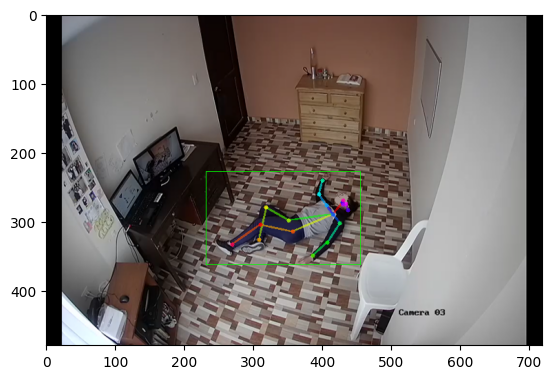

In [7]:
preds = process_one_image_with_bbox(img_path, pose_estimator, visualizer, show_interval=0)
img_output = visualizer.get_image()
# Convert BGR to RGB
img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)
plt.imshow(img_output)

In [14]:
preds.to_dict().keys()

dict_keys(['keypoints', 'bboxes', 'keypoint_scores', 'bbox_scores'])

In [16]:
num_instances = len(preds.to_dict()['bboxes'])

1

In [20]:
def instances_list_from_preds(preds):
    instances_list = []
    pred_dict = preds.to_dict()
    for i in range(len(pred_dict['bboxes'])):
        instance = {}
        instance['keypoints'] = pred_dict['keypoints'][i].tolist()
        instance['keypoint_scores'] = pred_dict['keypoint_scores'][i].tolist()
        instance['bbox'] = pred_dict['bboxes'][i].tolist()
        instance['bbox_score'] = pred_dict['bbox_scores'][i]
        instances_list.append(instance)
    
    return instances_list

In [21]:
instances_list_from_preds(preds)

[{'keypoints': [[430.0417879689485, 273.1665278971195],
   [435.14595286455005, 275.3540271380916],
   [431.5001207962632, 270.24986224249005],
   [438.7917849328369, 284.8331905156374],
   [431.5001207962632, 276.083193551749],
   [426.39595590066165, 303.0623508570716],
   [407.4376291455701, 277.5415263790637],
   [408.16679555922747, 331.4998409897089],
   [396.5001329407096, 261.49986527860165],
   [387.0209695631638, 350.45816774480045],
   [401.60429783631116, 241.81237210985273],
   [358.5834794305265, 315.4581798892468],
   [352.75014812126756, 299.41651878878474],
   [311.916828956455, 305.2498500980437],
   [319.20849309302866, 280.4581920336932],
   [270.35434337798506, 334.41650664433837],
   [309.7293297154829, 327.85400892142206]],
  'keypoint_scores': [0.7076385021209717,
   0.7495566606521606,
   0.7275708317756653,
   0.7255622744560242,
   0.7494524121284485,
   0.7691960334777832,
   0.771282434463501,
   0.7733641266822815,
   0.6430152654647827,
   0.7484871149063

## Test on a video

In [10]:
path_video = '../../Data/Fall/Dataset_CAUCAFall/CAUCAFall/video/FallBackwardsS1.avi'
path_imgs = '../../Data/Fall/Dataset_CAUCAFall/CAUCAFall/Subject.1/Fall backwards/'
info_dict = get_video_info_dict(path_video)
print(info_dict)

{'num_frames': 125, 'fps': 20.0, 'codec': 'XVID', 'width': 720, 'height': 480, 'duration': 6.25}


In [20]:
path_split = path_imgs.split("/")
subject_number = path_split[-3].split(".")[-1]
action_split = path_split[-2].split(" ")
if len(action_split) > 1:
    action_split[1] = action_split[1].capitalize()
path_split

['..',
 '..',
 'Data',
 'Fall',
 'Dataset_CAUCAFall',
 'CAUCAFall',
 'Subject.1',
 'Fall backwards',
 '']

In [26]:
path_video = os.sep.join(path_split[:-3]) + '/video/' + ''.join(action_split) + 'S' + subject_number + '.avi'

'../../Data/Fall/Dataset_CAUCAFall/CAUCAFall/video/FallBackwardsS1.avi'

In [10]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writter = cv2.VideoWriter('output.avi', fourcc, 30, (info_dict['width'], info_dict['height']))

In [11]:
imgs_list = os.listdir(path_imgs)
imgs_list.sort()
print(imgs_list)

['cas100001.png', 'cas100001.txt', 'cas100002.png', 'cas100002.txt', 'cas100003.png', 'cas100003.txt', 'cas100004.png', 'cas100004.txt', 'cas100005.png', 'cas100005.txt', 'cas100006.png', 'cas100006.txt', 'cas100007.png', 'cas100007.txt', 'cas100008.png', 'cas100008.txt', 'cas100009.png', 'cas100009.txt', 'cas100010.png', 'cas100010.txt', 'cas100011.png', 'cas100011.txt', 'cas100012.png', 'cas100012.txt', 'cas100013.png', 'cas100013.txt', 'cas100014.png', 'cas100014.txt', 'cas100015.png', 'cas100015.txt', 'cas100016.png', 'cas100016.txt', 'cas100017.png', 'cas100017.txt', 'cas100018.png', 'cas100018.txt', 'cas100019.png', 'cas100019.txt', 'cas100020.png', 'cas100020.txt', 'cas100021.png', 'cas100021.txt', 'cas100022.png', 'cas100022.txt', 'cas100023.png', 'cas100023.txt', 'cas100024.png', 'cas100024.txt', 'cas100025.png', 'cas100025.txt', 'cas100026.png', 'cas100026.txt', 'cas100027.png', 'cas100027.txt', 'cas100028.png', 'cas100028.txt', 'cas100029.png', 'cas100029.txt', 'cas100030.pn

In [12]:
num_frames = 0

imgs_list = os.listdir(path_imgs)
imgs_list.sort()

start_time = time.time()
for input in imgs_list:
    if input.endswith(".txt"):
        continue

    try:
        # topdown pose estimation
        pred_instances = process_one_image_with_bbox(path_imgs + input,
                                            pose_estimator, visualizer,
                                            0.000)
        img_output = visualizer.get_image()
    except:
        print("Fail")

    num_frames += 1
    fps = num_frames / (time.time() - start_time)
    print("FPS : ", fps)

    video_writter.write(img_output)



cas100001.png
FPS :  17.574022164959253
cas100002.png
FPS :  17.285193259510493
cas100003.png
FPS :  17.104132995317162
cas100004.png
FPS :  13.946831972640387
cas100005.png
FPS :  14.45317943455431
cas100006.png
FPS :  14.823149390542003
cas100007.png
FPS :  15.089913598286254
cas100008.png


FPS :  15.306414935628034
cas100009.png
FPS :  15.481668680376297
cas100010.png
FPS :  15.625544609857238
cas100011.png
FPS :  15.746625151067429
cas100012.png
FPS :  15.873825980877601
cas100013.png
FPS :  15.952748505982798
cas100014.png
FPS :  16.04063464035344
cas100015.png
FPS :  16.10685719391317
cas100016.png
FPS :  16.157203511741315
cas100017.png
FPS :  16.209933178485713
cas100018.png
FPS :  16.25236571329178
cas100019.png
FPS :  16.18453492381923
cas100020.png
FPS :  16.22880884572354
cas100021.png
FPS :  16.281856789049943
cas100022.png
FPS :  16.333494352955128
cas100023.png
FPS :  16.378128018300504
cas100024.png
FPS :  16.412666067638643
cas100025.png
FPS :  16.450026293033662
cas100026.png
FPS :  16.46597363315931
cas100027.png
FPS :  16.49171869559462
cas100028.png
FPS :  16.5329790245782
cas100029.png
FPS :  16.39485850205477
cas100030.png
FPS :  16.10615622223195
cas100031.png
FPS :  16.14871629655923
cas100032.png
FPS :  16.18855755243007
cas100033.png
FPS :  16.226